# Fixed-node DMC: spinless fermions in a 1D harmonic oscillator

This notebook runs **spinless (fully antisymmetric)** fermions using a Vandermonde-Gaussian
trial wavefunction. Fixed-node prevents walkers from crossing any surface $x_i = x_j$.


In [1]:
# Activate project environment and load dependencies.
using Pkg

project_root = "/Users/ismaelchona/PersonalProjects/DMC_project"
Pkg.activate(project_root)
Pkg.instantiate()

using System1D
using Random
using Statistics
using KernelDensity
using Plots

fig_dir = joinpath(project_root, "Notebooks", "figures")
mkpath(fig_dir)

  Activating project at `~/PersonalProjects/DMC_project`


"/Users/ismaelchona/PersonalProjects/DMC_project/Notebooks/figures"

## System setup

We use $\omega = 1$ and $D = 0.5$, so the 1D HO potential is $V(x)=\tfrac{1}{2}x^2$. In this case we used 4 particles. 


In [13]:
# Physics parameters.
omega = 1.0
D = 0.5
Nfermions = 4
@assert Nfermions >= 2

H = Hamiltonian(Nfermions, D, R -> 0.5 * sum(abs2, R))

# Simulation parameters.
nsteps = 2000
nequil = 500
targetN = 5_000
params = DMCParams(0.005, nsteps, nequil, targetN, 0.5 * omega * Nfermions^2, 0.0, 25, 100)

DMCParams(0.005, 2000, 500, 5000, 8.0, 0.0, 25, 100)

## Spinless trial wavefunction

For spinless fermions, the exact ground-state spatial wavefunction is

$$
\Psi(R) \propto \prod_{i<j} (x_i - x_j)\,\exp\left(-\frac{\alpha}{2}\sum_i x_i^2\right),
$$

with $\alpha = \omega$ in our units. We use a small softening $\varepsilon$ to avoid singularities.


In [3]:
alpha = omega
eps = 1e-6

# Sign of the Vandermonde factor (zero near nodes).
function signpsi(R; tol=1e-10)
    n = length(R)
    s = 1.0
    for i in 1:n-1
        for j in i+1:n
            dx = R[i] - R[j]
            if abs(dx) < tol
                return 0.0
            end
            s *= sign(dx)
        end
    end
    return s
end

# log|Psi| = sum_{i<j} log|x_i - x_j| - alpha/2 * sum x_i^2.
function logpsi(R)
    n = length(R)
    sumlog = 0.0
    for i in 1:n-1
        for j in i+1:n
            dx = R[i] - R[j]
            sumlog += 0.5 * log(dx^2 + eps^2)
        end
    end
    return sumlog - 0.5 * alpha * sum(abs2, R)
end

# grad log|Psi| for drift.
function gradlogpsi(R)
    n = length(R)
    grad = zeros(n)
    for i in 1:n
        xi = R[i]
        acc = 0.0
        for j in 1:n
            j == i && continue
            dx = xi - R[j]
            acc += dx / (dx^2 + eps^2)
        end
        grad[i] = acc - alpha * xi
    end
    return grad
end

# div(F) with F = 2 * grad log|Psi|.
function divdrift(R)
    n = length(R)
    sum_pair = 0.0
    for i in 1:n-1
        xi = R[i]
        for j in i+1:n
            dx = xi - R[j]
            sum_pair += 1.0 / (dx^2 + eps^2)
        end
    end
    return -4.0 * sum_pair - 2.0 * alpha * n
end

lapllogpsi(R) = 0.5 * divdrift(R)

trial = System1D.TrialWF(logpsi, gradlogpsi, lapllogpsi, signpsi)
guiding = System1D.ImportanceGuiding(trial, H)

System1D.ImportanceGuiding{System1D.TrialWF{typeof(logpsi), typeof(gradlogpsi), typeof(lapllogpsi), typeof(signpsi)}, Hamiltonian{var"#23#24"}}(System1D.TrialWF{typeof(logpsi), typeof(gradlogpsi), typeof(lapllogpsi), typeof(signpsi)}(Main.logpsi, Main.gradlogpsi, Main.lapllogpsi, Main.signpsi), Hamiltonian{var"#23#24"}(4, 0.5, var"#23#24"()))

## Run simulation

In [4]:
selected_taus = [0.0, 0.5, 1.0, 2.0]
snapshot_steps = unique([round(Int, tau / params.dt) for tau in selected_taus])
0 in snapshot_steps || push!(snapshot_steps, 0)
snapshot_steps = sort(snapshot_steps)

seed = 1234
rng_init = MersenneTwister(seed)
rng_sim = MersenneTwister(seed + 1)
walkers = [Walker(2 .* rand(rng_init, Nfermions) .- 1) for _ in 1:targetN]

sim = DMCSim(H, params, walkers, rng_sim; guiding=guiding, nodepolicy=System1D.FixedNode())

# Only store snapshots at selected steps to save memory.
sim = System1D.run_simulation!(sim; snapshot_steps=snapshot_steps)

ET = sim.ET_history
pop = sim.population_history
energy = sim.energy_mean_history

snaps = Dict(step => sim.walker_positions_history[i] for (i, step) in enumerate(snapshot_steps))

# History index 1 corresponds to step 0.
tau = (0:nsteps) .* params.dt

0.0:0.005:10.0

## Reference (spinless HO)

Exact ground-state energy for spinless fermions:

$$
E_0 = \frac{\omega}{2} N^2.
$$

One-particle density:

$$
\rho_1(x) = \frac{1}{N}\sum_{n=0}^{N-1} |\phi_n(x)|^2.
$$


In [5]:
E_ref = 0.5 * omega * Nfermions^2
alpha_ref = omega

# Physicists' Hermite polynomials via recurrence.
function hermiteH(n, x)
    if n == 0
        return 1.0
    elseif n == 1
        return 2.0 * x
    end
    Hm2 = 1.0
    Hm1 = 2.0 * x
    for k in 1:n-1
        H = 2.0 * x * Hm1 - 2.0 * k * Hm2
        Hm2, Hm1 = Hm1, H
    end
    return Hm1
end

function phi_n_sq(n, x)
    Hn = hermiteH(n, sqrt(alpha_ref) * x)
    norm = sqrt(alpha_ref / pi) / (2.0^n * Float64(factorial(n)))
    return norm * Hn^2 * exp(-alpha_ref * x^2)
end

function rho1_ref(x)
    acc = 0.0
    for n in 0:(Nfermions - 1)
        acc += phi_n_sq(n, x)
    end
    return acc / Nfermions
end

# Grids for reference overlays, based on the last snapshot.
snap_ref = snaps[snapshot_steps[end]]
xs_ref = Float64[]
for R in snap_ref
    append!(xs_ref, R)
end
xmax = maximum(abs.(xs_ref))
xgrid = range(-1.1 * xmax, 1.1 * xmax, length=400)
rho1_ref_vals = [rho1_ref(x) for x in xgrid]

# Relative-coordinate reference only for N=2.
rel_ref_vals = nothing
rgrid = nothing
if Nfermions == 2
    rvals = [R[1] - R[2] for R in snap_ref]
    rmax = maximum(abs.(rvals))
    rgrid = range(-1.1 * rmax, 1.1 * rmax, length=400)
    rel_ref_vals = [(alpha_ref^(3/2) / sqrt(2 * pi)) * r^2 * exp(-0.5 * alpha_ref * r^2) for r in rgrid]
end

## Diagnostics

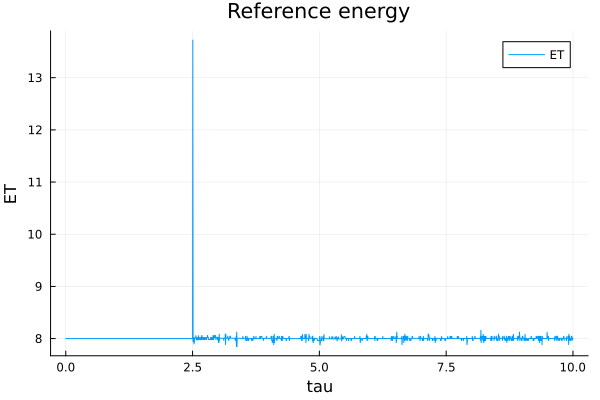

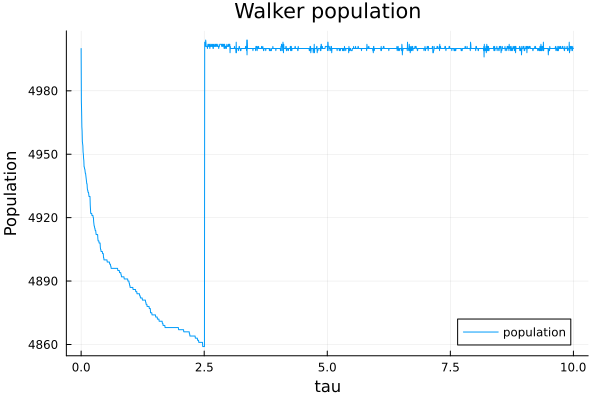

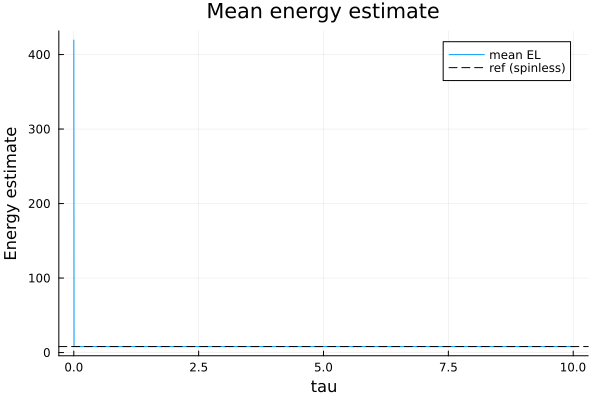

In [6]:
plt_ET = plot(tau, ET; label="ET", xlabel="tau", ylabel="ET", title="Reference energy")
savefig(plt_ET, joinpath(fig_dir, "spinless_ET_vs_tau.png"))
display(plt_ET)

plt_pop = plot(tau, pop; label="population", xlabel="tau", ylabel="Population", title="Walker population")
savefig(plt_pop, joinpath(fig_dir, "spinless_population_vs_tau.png"))
display(plt_pop)

plt_E = plot(tau, energy; label="mean EL", xlabel="tau", ylabel="Energy estimate", title="Mean energy estimate")
hline!(plt_E, [E_ref]; label="ref (spinless)", linestyle=:dash, color=:black)
savefig(plt_E, joinpath(fig_dir, "spinless_energy_vs_tau.png"))
display(plt_E)

## Single-particle marginals

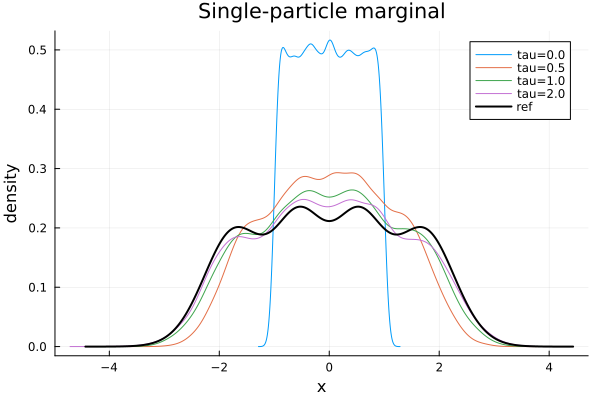

In [7]:
function collect_coords(snapshot)
    xs = Float64[]
    for R in snapshot
        append!(xs, R)
    end
    return xs
end

plt_marg = plot(; xlabel="x", ylabel="density", title="Single-particle marginal")
for s in snapshot_steps
    xs = collect_coords(snaps[s])
    kd = kde(xs)
    plot!(plt_marg, kd.x, kd.density; label="tau=$(round(s * params.dt, digits=2))")
end
plot!(plt_marg, xgrid, rho1_ref_vals; label="ref", linewidth=2, color=:black)
savefig(plt_marg, joinpath(fig_dir, "spinless_marginal_kde_vs_tau.png"))
display(plt_marg)

## Pairwise difference distribution

We plot $r = x_i - x_j$ for all pairs $(i < j)$ across walkers. The node is at $r = 0$.


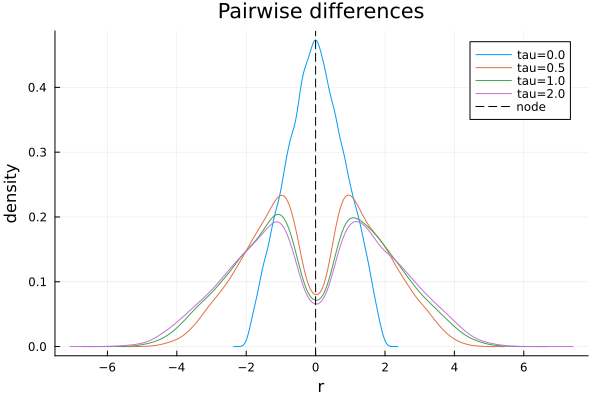

In [8]:
function pairwise_diffs(snapshot)
    diffs = Float64[]
    for R in snapshot
        n = length(R)
        for i in 1:n-1
            xi = R[i]
            for j in i+1:n
                push!(diffs, xi - R[j])
            end
        end
    end
    return diffs
end

plt_rel = plot(; xlabel="r", ylabel="density", title="Pairwise differences")
for s in snapshot_steps
    rvals = pairwise_diffs(snaps[s])
    kd = kde(rvals)
    plot!(plt_rel, kd.x, kd.density; label="tau=$(round(s * params.dt, digits=2))")
end
vline!(plt_rel, [0.0]; label="node", linestyle=:dash, color=:black)
if Nfermions == 2
    plot!(plt_rel, rgrid, rel_ref_vals; label="ref", linewidth=2, color=:black)
end
savefig(plt_rel, joinpath(fig_dir, "spinless_pairwise_kde_vs_tau.png"))
display(plt_rel)

## (x1, x2) scatter snapshots

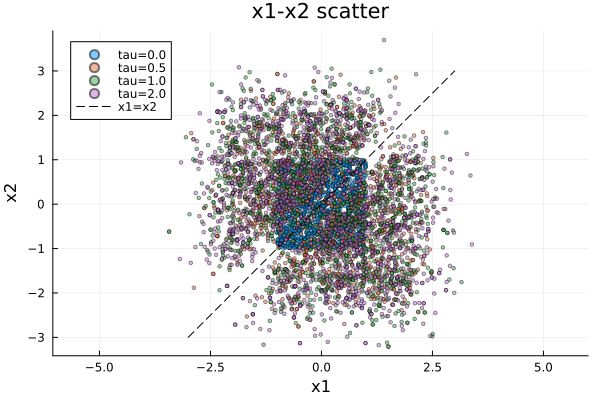

In [9]:
function scatter_snapshots(snaps, steps)
    plt = plot(; xlabel="x1", ylabel="x2", title="x1-x2 scatter", aspect_ratio=:equal)
    rng = MersenneTwister(2025)
    for s in steps
        snap = snaps[s]
        n = min(length(snap), 1500)
        idx = rand(rng, 1:length(snap), n)
        xs = [snap[i][1] for i in idx]
        ys = [snap[i][2] for i in idx]
        scatter!(plt, xs, ys; label="tau=$(round(s * params.dt, digits=2))", markersize=2, alpha=0.5)
    end
    plot!(plt, [-3, 3], [-3, 3]; label="x1=x2", linestyle=:dash, color=:black)
    return plt
end

plt_scatter = scatter_snapshots(snaps, snapshot_steps)
savefig(plt_scatter, joinpath(fig_dir, "spinless_scatter_x1_x2.png"))
display(plt_scatter)

## Energy estimate

In [10]:
start_idx = nequil + 2
E_mean = mean(energy[start_idx:end])
E_sem = std(energy[start_idx:end]) / sqrt(length(energy[start_idx:end]))
println("Spinless mean energy (after equil): $(round(E_mean, digits=4)) +/- $(round(E_sem, digits=4))")

Spinless mean energy (after equil): 8.0005 +/- 0.0
